In [2]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy.interpolate
import matplotlib as mpl
import errno
mpl.rcParams['pdf.fonttype'] = 42

# Get zscore
def GetZscore(data, col):
    m = np.mean(data[col])
    s = np.sqrt(np.var(data[col]))
    return data.apply(lambda x: (x[col]-m)/s, 1)    

Populating the interactive namespace from numpy and matplotlib


## Read bed file of 12 time points and references
Exp 2 is being read

In [16]:
data_array = []
# background = pd.read_csv("./counts/exp1_0hr_WCE_HJW7KBGXX.dupsRemoved.merged.sorted.counts.bed", sep="\t", names=["chrom","start","end","readcount"])

for i in [0,1,1.5,2,2.5,3,4,5,5.5,6,7,8]:
    try:
        data = pd.read_csv("./counts/exp2_"+str(i)+"hr_WCE_HJWMVBGXX.dupsRemoved.merged.sorted.counts.bed", sep="\t", names=["chrom","start","end","readcount"])
    except FileNotFoundError:
        data = pd.read_csv("./counts/exp2_"+str(i)+"hr_WCE_HJW7KBGXX.dupsRemoved.merged.sorted.counts.bed", sep="\t", names=["chrom","start","end","readcount"])
#     data["ratio"] = data['readcount']/background['readcount']
    m = np.mean(data["readcount"])
    s = np.sqrt(np.var(data["readcount"]))
    print(i, m, m+3*s, m-3*s)

    data = data[data["readcount"]<=m+3*s]

    data["zscore"] = GetZscore(data, "readcount")

    # Restrict to region from mccarroll paper
    Mb = 1000000
    minval = 50
    maxval = 90
    data = data[(data["start"]>=minval*Mb) & (data["start"]<=maxval*Mb)]

    data_array.append((data, "exp1_"+str(i)+"hr_WCE"))
    
# Load Koren data
# koren = pd.read_csv("data/Koren_etal_TableS2_hg19.bed", sep="\t", names=["chrom","start","end","zscore"])
# koren = koren[(koren["chrom"]=="chr2") & (koren["start"]>=minval*Mb) & (koren["start"]<=maxval*Mb)]

# Load rep1 data
rep1 = pd.read_csv("data/L1210_ToR_rep1.bed",sep="\t", names=["chrom","start","end","zscore"])
rep1 = rep1[(rep1["chrom"]=="chr2") & (rep1["start"]>=minval*Mb) & (rep1["start"]<=maxval*Mb)]
rep1['zscore'] = rep1['zscore'].astype(float)
# Load rep2 data
rep2 = pd.read_csv("data/L1210_ToR_rep2.bed",sep="\t", names=["chrom","start","end","zscore"])
rep2 = rep2[(rep1["chrom"]=="chr2") & (rep2["start"]>=minval*Mb) & (rep2["start"]<=maxval*Mb)]
rep2['zscore'] = rep2['zscore'].astype(float)
# Load Gilbert data
gilbert = pd.read_csv("data/L1210_ToR_gilbert.bed",sep="\t", names=["chrom","start","end","zscore"])
gilbert = gilbert[(rep1["chrom"]=="chr2") & (gilbert["start"]>=minval*Mb) & (gilbert["start"]<=maxval*Mb)]
gilbert['zscore'] = gilbert['zscore'].astype(float)

0 4916.24253292 190336.315804 -180503.830738
1 4888.08512188 191283.574637 -181507.404393
1.5 5397.94143854 197877.858384 -187081.975507
2 4815.46905035 190999.810316 -181368.872216
2.5 4488.19485541 190061.010269 -181084.620558
3 4566.75184936 187192.398996 -178058.895297
4 4639.21819048 185848.456875 -176570.020494
5 3781.13673298 176218.512849 -168656.239383
5.5 4729.44491145 191084.199596 -181625.309773
6 4281.69979546 183260.108492 -174696.708902
7 5046.28041468 200130.700857 -190038.140027
8 4510.10916223 191444.766346 -182424.548021


## Display Histogram

/usr/lib64/python3.4/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


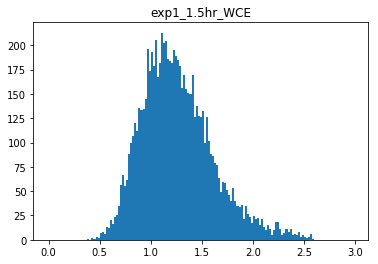

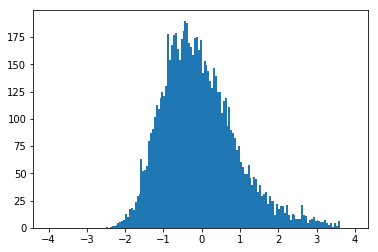

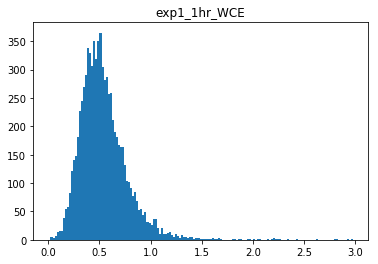

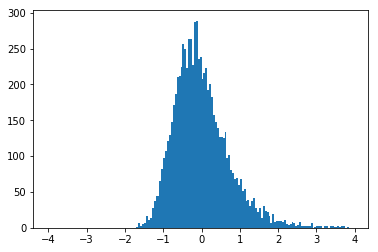

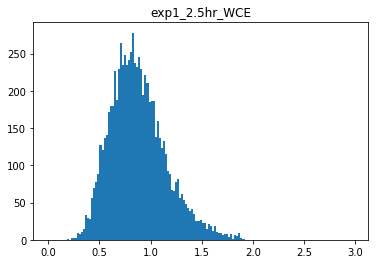

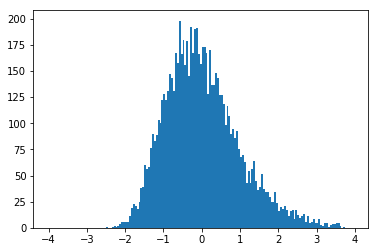

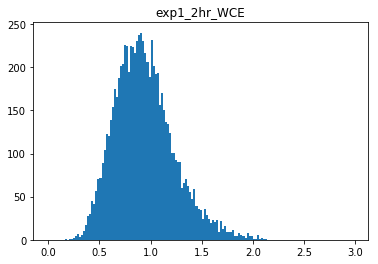

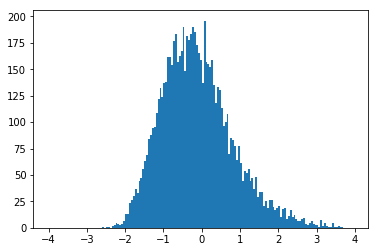

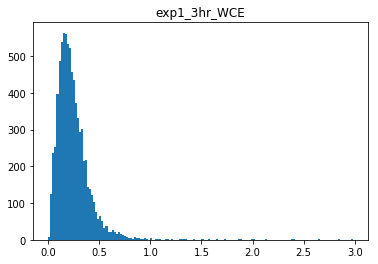

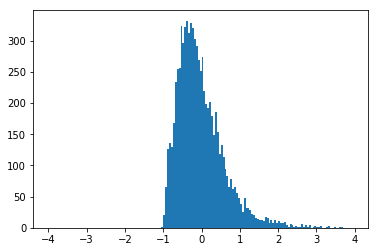

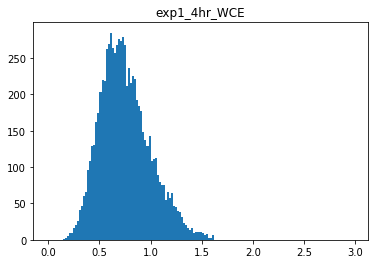

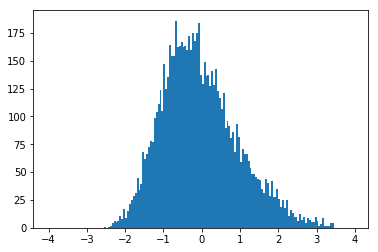

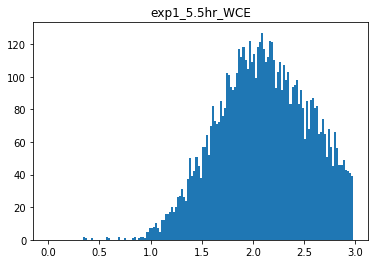

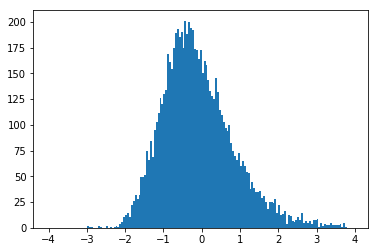

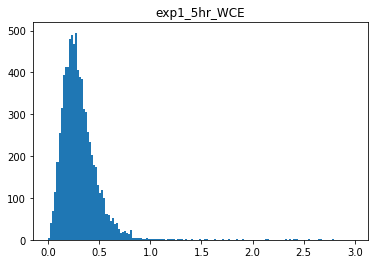

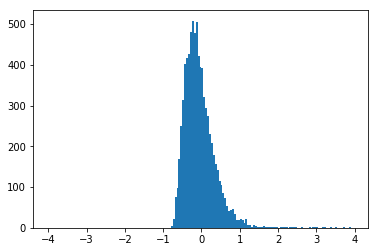

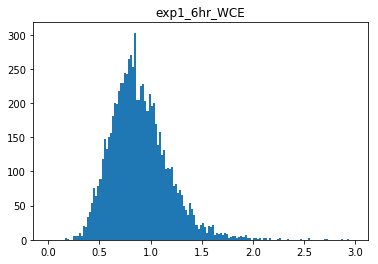

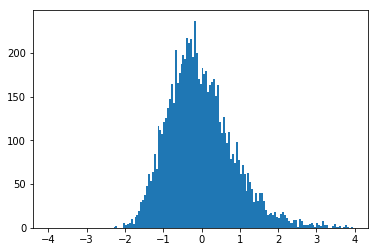

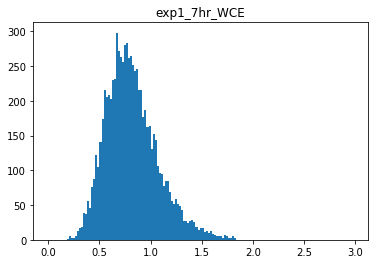

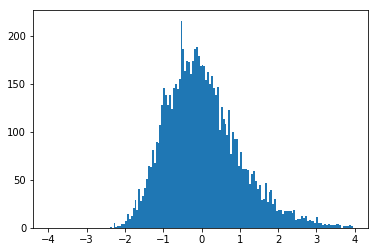

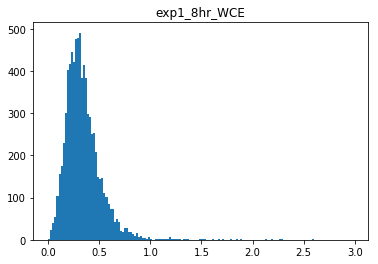

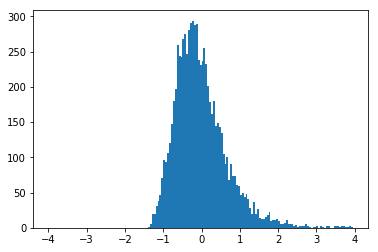

In [7]:
for data in data_array:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.title.set_text(data[1])
    ax.hist(data[0]["ratio"], bins=np.arange(0, 3, 0.02))

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(data[0]["zscore"], bins = np.arange(-4, 4, 0.05));

## Get smoothed x and y values in 12 samples

In [20]:
WINDOWSTEP=5000
def Smooth(data, windows=20, column="zscore", thin=10):
    newx = []
    newy = []
#     print(data.shape[0])
    # For each x, get +/- 10 windows
    for i in range(data.shape[0]):
        center = data.start.values[i]
        beginwindow = center - windows/2*WINDOWSTEP
        endwindow = center + (windows/2+1)*WINDOWSTEP
        x = data[(data["start"]>=beginwindow) & (data["end"]<=endwindow)]
#         print(center, beginwindow, endwindow)
        if x.shape[0] == windows:
            newx.append(center)
            newy.append(np.mean(x[column]))
        else:
            newx.append(np.nan)
            newy.append(np.nan)
    ind = [i for i in range(len(newx)) if i%thin == 0]
    return np.array(newx)[ind], np.array(newy)[ind]

In [21]:
xarray = []
yarray = []
for data in data_array:
    xnew, ynew = Smooth(data[0], windows=100)
    xarray.append(xnew)
    yarray.append(ynew)

## Plot all figures together

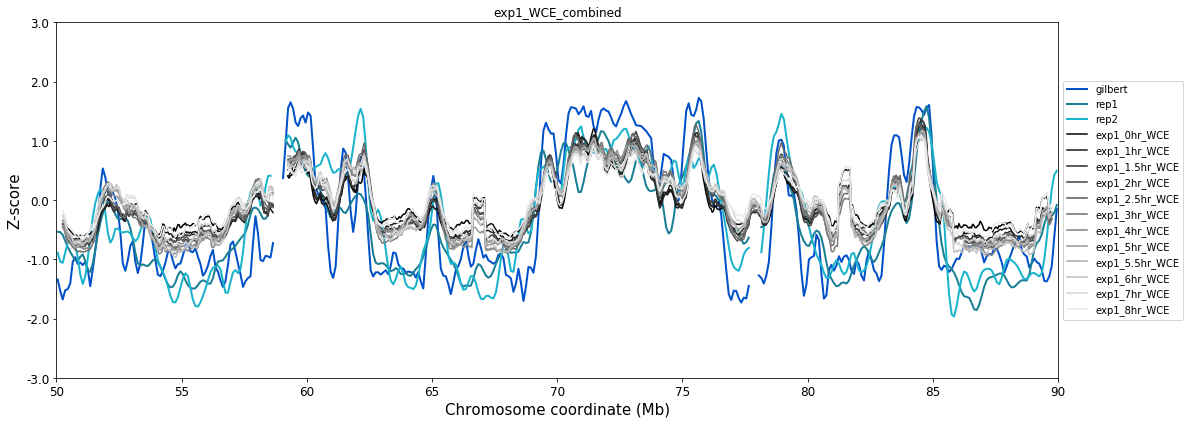

In [22]:
fig = plt.figure()
lines = []

ax = fig.add_subplot(111)
# Plot koren
# ax.plot(koren["start"], koren["zscore"], color="blue", lw=2)

# plot reference
ax.plot(gilbert["start"], gilbert["zscore"], color="#0050c9", lw=2, label="gilbert")
ax.plot(rep1["start"], rep1["zscore"], color="#197f94", lw=2, label="rep1")
ax.plot(rep2["start"], rep2["zscore"], color="#19b3cb", lw=2, label="rep2")
ax.set_title("exp1_WCE_combined")

i = 0
for data in data_array:
    xnew, ynew = xarray[i],yarray[i]
    
    # get color scheme
    jet = cm = plt.get_cmap('gray') 
    
    cNorm  = mpl.colors.Normalize(vmin=0, vmax=12)
    scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=jet)
#     print scalarMap.get_clim()

    colorVal = scalarMap.to_rgba(i)
    colorText = ('color: (%4.2f,%4.2f,%4.2f)'%(colorVal[0],colorVal[1],colorVal[2]))
    retLine, = ax.plot(list(xnew),list(ynew),color=colorVal,label=data[1])
    lines.append(retLine)
    i+=1

# ax.plot(list(xnew), list(ynew), color="black", lw=2)
# ax.scatter(data[0]["start"], data[0]["zscore"], color="gray", alpha=0.1)
ax.set_xlim(left=minval*Mb, right=maxval*Mb);
ax.set_ylim(bottom=-3, top=3)
ax.set_xlabel("Chromosome coordinate (Mb)", size=15);
ax.set_ylabel("Z-score", size=15);
ax.set_xticklabels(map(lambda x: int(x/Mb), ax.get_xticks()), size=12);
ax.set_yticklabels(ax.get_yticks(), size=12);
handles,labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(15,6, forward=True)
fig.tight_layout()
fig.savefig("exp2_WCE_combined.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


## Plot figures seperately

0
1
2
3
4
5
6
7
8
9
10
11


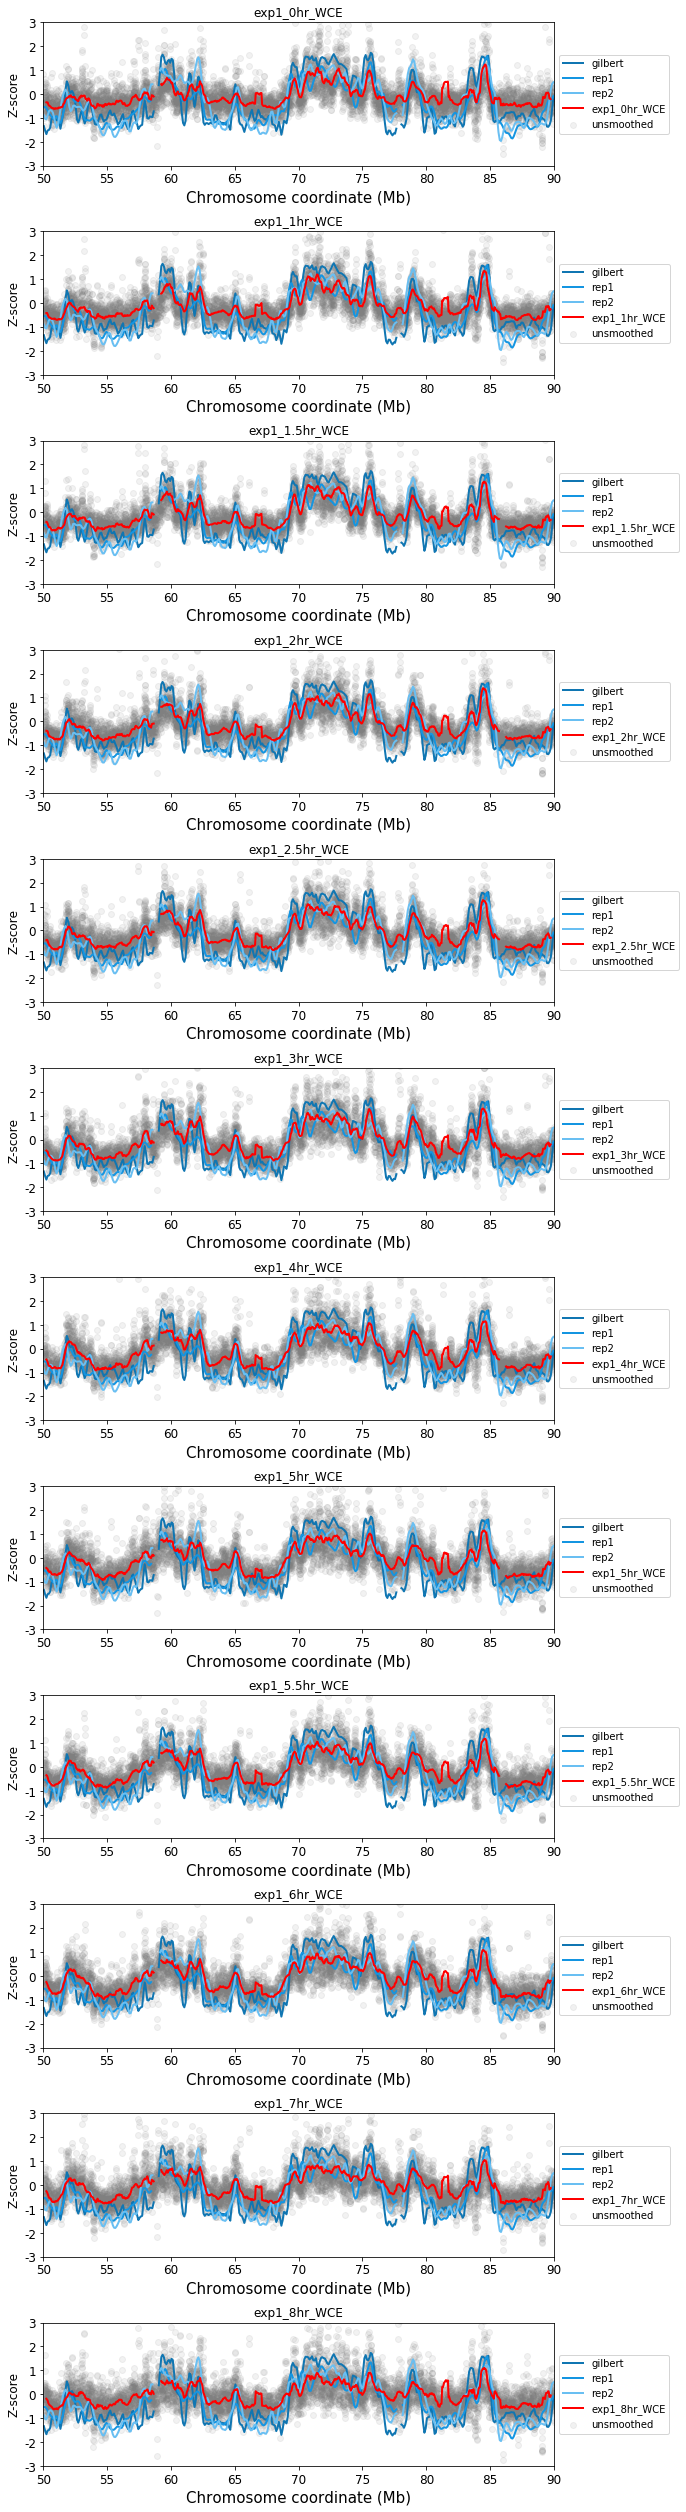

In [23]:

fig = plt.figure()
# Plot koren
# ax.plot(koren["start"], koren["zscore"], color="blue", lw=2)

i = 0
for data in data_array:
    print(i)
    xnew, ynew = xarray[i],yarray[i]

    ax = fig.add_subplot(12,1,i+1)
    ax.set_title(data[1])


    # plot reference
    ax.plot(gilbert["start"], gilbert["zscore"], color="#1076b2", lw=2, label="gilbert")
    ax.plot(rep1["start"], rep1["zscore"], color="#1495e1", lw=2, label="rep1")
    ax.plot(rep2["start"], rep2["zscore"], color="#69bff2", lw=2, label="rep2")

    # plot data
    ax.scatter(data[0]["start"], data[0]["zscore"], color="gray", label="unsmoothed", alpha=0.1)
    ax.plot(list(xnew),list(ynew),color="red",lw=2, label=data[1])
    i+=1

    # ax.plot(list(xnew), list(ynew), color="black", lw=2)

    ax.set_xlim(left=minval*Mb, right=maxval*Mb);
    ax.set_ylim(bottom=-3, top=3)
    ax.set_xlabel("Chromosome coordinate (Mb)", size=15);
    ax.set_ylabel("Z-score", size=12);
    ax.set_xticklabels(map(lambda x: int(x/Mb), ax.get_xticks()), size=12);
    ax.set_yticklabels(range(-3,4,1), size=12);
    handles,labels = ax.get_legend_handles_labels()
    lgd = ax.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(8,35, forward=True)
fig.tight_layout()
fig.savefig("exp2_WCE_seperate.pdf",bbox_extra_artists=(lgd,), bbox_inches='tight')